In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns

In [3]:
sns.set_context('poster', font_scale=1.25)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import D2Q9_LB as lb

/home/bryan/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [15]:
sim = lb.Pipe_Flow(lx=100, ly=100)

In [16]:
sim.run(1000)

In [17]:
sim.u

array([[  0.00000000e+00,   1.10128030e-04,   3.68120839e-04, ...,
          3.69897772e-04,   1.12850527e-04,  -8.57753115e-05],
       [ -4.16325526e-17,   1.24070521e-04,   3.67487055e-04, ...,
          3.71328622e-04,   1.21336582e-04,  -4.29154337e-05],
       [ -4.16331929e-17,   1.30767388e-04,   3.79917972e-04, ...,
          3.86284938e-04,   1.33508193e-04,  -2.14727206e-05],
       ..., 
       [ -2.14720666e-05,   1.31083971e-04,   3.83459231e-04, ...,
          3.81056122e-04,   1.31200931e-04,   0.00000000e+00],
       [ -4.29104810e-05,   1.22227367e-04,   3.71616752e-04, ...,
          3.68006306e-04,   1.23998730e-04,   0.00000000e+00],
       [ -8.57574971e-05,   1.12253542e-04,   3.68667137e-04, ...,
          3.68827389e-04,   1.10306902e-04,   6.24488191e-17]])

array([[  0.00000000e+00,   1.10128030e-04,   3.68120839e-04, ...,
          3.69897772e-04,   1.12850527e-04,  -8.57753115e-05],
       [ -4.16325526e-17,   1.24070521e-04,   3.67487055e-04, ...,
          3.71328622e-04,   1.21336582e-04,  -4.29154337e-05],
       [ -4.16331929e-17,   1.30767388e-04,   3.79917972e-04, ...,
          3.86284938e-04,   1.33508193e-04,  -2.14727206e-05],
       ..., 
       [ -2.14720666e-05,   1.31083971e-04,   3.83459231e-04, ...,
          3.81056122e-04,   1.31200931e-04,   0.00000000e+00],
       [ -4.29104810e-05,   1.22227367e-04,   3.71616752e-04, ...,
          3.68006306e-04,   1.23998730e-04,   0.00000000e+00],
       [ -8.57574971e-05,   1.12253542e-04,   3.68667137e-04, ...,
          3.68827389e-04,   1.10306902e-04,   6.24488191e-17]])

<matplotlib.colorbar.Colorbar instance at 0x7efe95812a70>

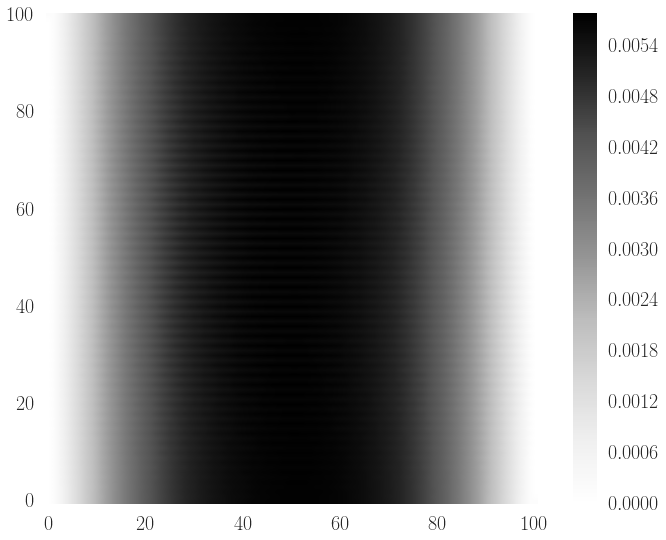

In [29]:
v_mag = np.sqrt(sim.u**2 + sim.v**2)
plt.imshow(v_mag, origin='lower')
plt.grid(False)
plt.colorbar()

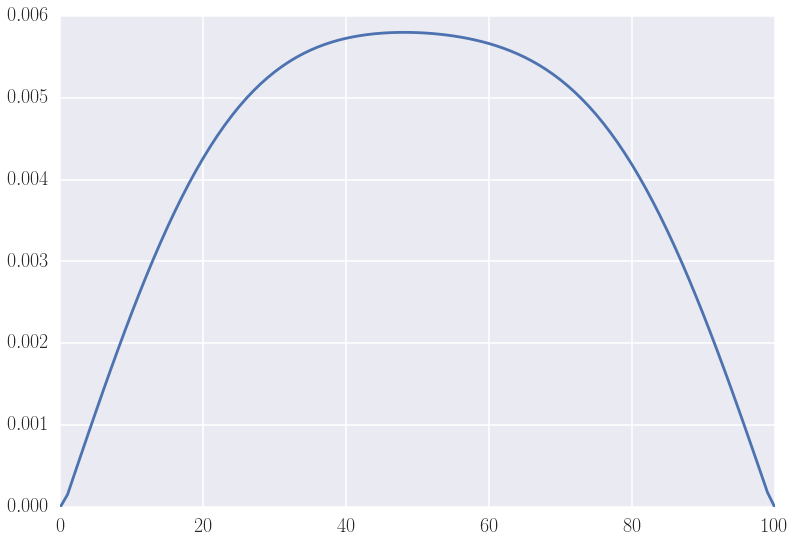

In [26]:
plt.plot(v_mag[50, :])

Wow, awesome, it looks like it worked! Except everything is facing the wrong way...lol. Let's wrap the slow piece in cython as well.

In [4]:
w=np.array([4./9.,1./9.,1./9.,1./9.,1./9.,1./36.,    
            1./36.,1./36.,1./36.]) # weights for directions
cx=np.array([0,1,0,-1,0,1,-1,-1,1]) # direction vector for the x direction
cy=np.array([0,0,1,0,-1,1,1,-1,-1]) # direction vector for the y direction
tau=1
cs=1/math.sqrt(3)
cs2 = cs**2
cs22 = 2*cs2
cssq = 2.0/9.0

w0 = 4./9.
w1 = 1./9.
w2 = 1./36.

In [5]:
viscosity = cs**2*(tau-0.5)
print 'Viscosity is:' , viscosity

Viscosity is: 0.166666666667


In [6]:
lx=400  # length of domain in the x direction
# extend by one to deal with domain boundaries at walls...
nx = lx + 1
ly=400  # length of domain in the y direction
ny = ly + 1

We know that

$\nu = \frac{\Delta x^2}{3 \Delta t}(w - \frac{1}{2})$

from my engineering book, or

$\nu = c_s^2(\tau-\frac{1}{2})=c_s^2(\frac{1}{w}-\frac{1}{2})$

We begin by calculating macrosocpic quantities. The initial conditions. Let's make constant density everywhere of one.

In [7]:
rho = np.ones((nx, ny))
u_applied=cs/100
u = u_applied*(np.ones((nx, ny)) + np.random.randn(nx,ny))
v= (u_applied/100.)*(np.ones((nx, ny)) + np.random.randn(nx,ny)) # initializing the vertical velocities

In [8]:
f=np.zeros((9,nx,ny)) # initializing f
feq = np.zeros((9, nx, ny))

We know that $\sum_i w_i f_i = \rho$, so

Let's just do this ourselves. Ok, so we have f0. We now need to stream and update the density array. 

In [9]:
# Taken from sauro succi's code. This will be super easy to put on the GPU.

def update_feq():
    ul = u/cs2
    vl = v/cs2
    uv = ul*vl
    usq = u*u
    vsq = v*v
    sumsq  = (usq+vsq)/cs22
    sumsq2 = sumsq*(1.-cs2)/cs2
    u2 = usq/cssq 
    v2 = vsq/cssq

    feq[0, :, :] = w0*(1. - sumsq)

    feq[1, :, :] = w1*(1. - sumsq  + u2 + ul)
    feq[2, :, :] = w1*(1. - sumsq  + v2 + vl)
    feq[3, :, :] = w1*(1. - sumsq  + u2 - ul)
    feq[4, :, :] = w1*(1. - sumsq  + v2 - vl)
    feq[5, :, :] = w2*(1. + sumsq2 + ul + vl + uv)
    feq[6, :, :] = w2*(1. + sumsq2 - ul + vl - uv)
    feq[7, :, :] = w2*(1. + sumsq2 - ul - vl + uv)
    feq[8, :, :] = w2*(1. + sumsq2 + ul - vl - uv)

In [10]:
update_feq()

Ok, we now have to initialize the populations. Close to the equilibrium states.

In [11]:
f = feq.copy()
# We now slightly perturb f
amplitude = .01
perturb = (1. + amplitude*np.random.randn(nx, ny))
f *= perturb

We have initialized feq and f, as well as the hydrodynamic variables. We now move. We have to deal with the boundary conditions as well as the non-boundary conditions. If we want to be smart, we probably have to avoid rolling, and write our own stuff...but we'll see.

In [12]:
def move_bcs():
    # West inlet: periodic BC's
    for j in range(1,ly):
        f[1,0,j] = f[1,lx,j]
        f[5,0,j] = f[5,lx,j]
        f[8,0,j] = f[8,lx,j]
    # EAST outlet
    for j in range(1,ly):
        f[3,lx,j] = f[3,0,j]
        f[6,lx,j] = f[6,0,j]
        f[7,lx,j] = f[7,0,j]
    # NORTH solid
    for i in range(1, lx): # Bounce back
        f[4,i,ly] = f[2,i,ly-1]
        f[8,i,ly] = f[6,i+1,ly-1]
        f[7,i,ly] = f[5,i-1,ly-1]
    # SOUTH solid
    for i in range(1, lx):
        f[2,i,0] = f[4,i,1]
        f[6,i,0] = f[8,i-1,1]
        f[5,i,0] = f[7,i+1,1]
        
    # Corners bounce-back
    f[8,0,ly] = f[6,1,ly-1]
    f[5,0,0]  = f[7,1,1]
    f[7,lx,ly] = f[5,lx-1,ly-1]
    f[6,lx,0]  = f[8,lx-1,1]

In [13]:
def move():
    for j in range(ly,0,-1): # Up, up-left
        for i in range(0, lx):
            f[2,i,j] = f[2,i,j-1]
            f[6,i,j] = f[6,i+1,j-1]
    for j in range(ly,0,-1): # Right, up-right
        for i in range(lx,0,-1):
            f[1,i,j] = f[1,i-1,j]
            f[5,i,j] = f[5,i-1,j-1]
    for j in range(0,ly): # Down, right-down
        for i in range(lx,0,-1):
            f[4,i,j] = f[4,i,j+1]
            f[8,i,j] = f[8,i-1,j+1]
    for j in range(0,ly): # Left, left-down
        for i in range(0, lx):
            f[3,i,j] = f[3,i+1,j]
            f[7,i,j] = f[7,i+1,j+1]

In [14]:
move()

Ok. Good. I think we have all components to run the flow! :)